In [13]:
import librosa
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import seaborn as sns
import warnings
from glob import glob
import pandas as pd

In [14]:
import pickle
with open("mfccs_feature.pkl", "rb") as f:
    mfccs_feature = pickle.load(f)
with open("classes.pkl", "rb") as f:
    classes = pickle.load(f)

In [15]:
df = pd.DataFrame({'MFCC_Features': mfccs_feature, 'Class': classes})
df.shape
print(df['Class'].unique())

df = df[df['Class'] != 'Punjabi']
df.shape

['Bengali' 'Gujarati' 'Hindi' 'Kannada' 'Malayalam' 'Marathi' 'Punjabi'
 'Tamil' 'Telugu' 'Urdu']


(44998, 2)

In [16]:
new_df = df.sample(44998)
print(df['Class'].unique())

new_df.head()

['Bengali' 'Gujarati' 'Hindi' 'Kannada' 'Malayalam' 'Marathi' 'Tamil'
 'Telugu' 'Urdu']


,MFCC_Features,Class
42252,"[-328.44, 58.00972, -25.735231, 40.162205, -10...",Telugu
730,"[-291.3887, 153.06038, 13.893982, 30.708715, -...",Bengali
2492,"[-366.7138, 124.8129, 18.32579, -0.08555846, -...",Bengali
47204,"[-347.56418, 121.14945, -1.9480261, 76.73031, ...",Urdu
5425,"[-276.08142, 137.63875, -43.792995, 9.063978, ...",Gujarati


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import math
from torch import Tensor
import torch
from einops import rearrange
import torch.nn.functional as F
from einops.layers.torch import Rearrange,Reduce

In [18]:
lbl = LabelEncoder()
y = lbl.fit_transform(new_df['Class'])
X = np.array(new_df['MFCC_Features'].tolist())
y = np.array(y.tolist())

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [19]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, expansion, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)

        self.ff = nn.Sequential(
            nn.Linear(embed_dim, expansion * embed_dim),
            nn.ReLU(),
            nn.Linear(expansion*embed_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, src_mask=None, src_key_padding_mask=None):
        attn_output, _ = self.attention(x, x, x, attn_mask=src_mask,
                                        key_padding_mask=src_key_padding_mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)
        ff_output = self.ff(x)
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)

        return x

In [20]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size, n_classes):
        super().__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(emb_size, 256),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(256, 32),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(32, n_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.fc(x)
        return out

In [21]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth, emb_size):
        super().__init__(*[TransformerEncoderBlock(emb_size,num_heads=5,expansion=4) for _ in range(depth)])
class Classifier(nn.Sequential):
    def __init__(self, emb_size=40, depth=3, **kwargs):
        super().__init__(
            TransformerEncoder(depth, emb_size),
            ClassificationHead(emb_size, 9)
        )
        

In [31]:
# Ensure the model is on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
model = Classifier().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Convert data to PyTorch tensors and move to GPU
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

# Training loop
epochs = 100
batch_size = 16
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(X_train_tensor):.4f}")

Epoch 1/100, Loss: 0.1202
Epoch 2/100, Loss: 0.1077
Epoch 3/100, Loss: 0.1033
Epoch 4/100, Loss: 0.0994
Epoch 5/100, Loss: 0.0979
Epoch 6/100, Loss: 0.0971
Epoch 7/100, Loss: 0.0964
Epoch 8/100, Loss: 0.0958
Epoch 9/100, Loss: 0.0951
Epoch 10/100, Loss: 0.0944
Epoch 11/100, Loss: 0.0939
Epoch 12/100, Loss: 0.0935
Epoch 13/100, Loss: 0.0931
Epoch 14/100, Loss: 0.0924
Epoch 15/100, Loss: 0.0920
Epoch 16/100, Loss: 0.0916
Epoch 17/100, Loss: 0.0914
Epoch 18/100, Loss: 0.0911
Epoch 19/100, Loss: 0.0909
Epoch 20/100, Loss: 0.0905
Epoch 21/100, Loss: 0.0900
Epoch 22/100, Loss: 0.0899
Epoch 23/100, Loss: 0.0896
Epoch 24/100, Loss: 0.0894
Epoch 25/100, Loss: 0.0891
Epoch 26/100, Loss: 0.0890
Epoch 27/100, Loss: 0.0888
Epoch 28/100, Loss: 0.0888
Epoch 29/100, Loss: 0.0886
Epoch 30/100, Loss: 0.0885
Epoch 31/100, Loss: 0.0885
Epoch 32/100, Loss: 0.0884
Epoch 33/100, Loss: 0.0883
Epoch 34/100, Loss: 0.0882
Epoch 35/100, Loss: 0.0882
Epoch 36/100, Loss: 0.0882
Epoch 37/100, Loss: 0.0881
Epoch 38/1

In [34]:
torch.save(model.state_dict(), "transformer_classifier.pth")

In [32]:
# Convert test data to PyTorch tensors and move to GPU
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Set the model to evaluation mode
model.eval()

# Get predictions
with torch.no_grad():
    outputs = model(X_test_tensor)
    y_pred = torch.argmax(outputs, dim=1).cpu().numpy()

# Evaluate the model
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9809


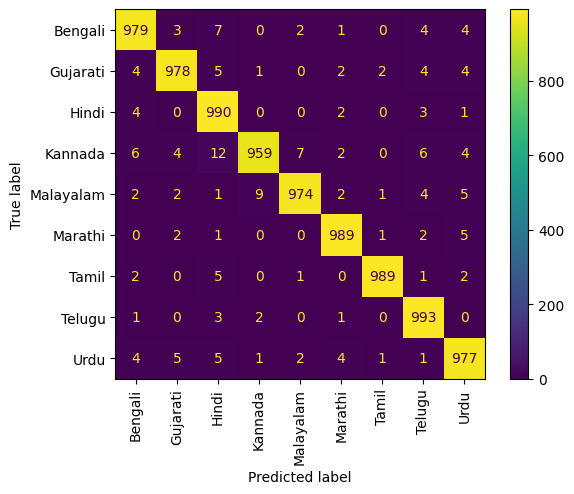

In [33]:
cnf = confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay(cnf,display_labels=lbl.classes_).plot()
plt.xticks(rotation=90)
plt.show()

In [53]:
def feature_extractor(file):
    audio_data,sample_rate = librosa.load(file)
    mfcc_feature = librosa.feature.mfcc(y=audio_data,sr=sample_rate,n_mfcc=40)
    scaled_feature = np.mean(mfcc_feature.T,axis=0)
    return scaled_feature
mfccs_feature_custom = []
classes_custom = []
file = "hindi_harsh_high.mp3"
mfccs_feature_custom.append(feature_extractor(file))
classes_custom.append("Hindi")


print("done")

/tmp/ipykernel_298514/4130423629.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data,sample_rate = librosa.load(file)
/home/teaching/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'hindi_harsh_high.mp3'

In [52]:
# Convert mfccs_feature_custom to a PyTorch tensor and move to the appropriate device
if mfccs_feature_custom:
    custom_features_tensor = torch.tensor(mfccs_feature_custom, dtype=torch.float32).to(device)

    # Forward pass through the model
    model.eval()
    with torch.no_grad():
        custom_outputs = model(custom_features_tensor)
        custom_predictions = torch.argmax(custom_outputs, dim=1).cpu().numpy()

    # Map predictions back to class labels
    predicted_classes = lbl.inverse_transform(custom_predictions)
    print(f"Predicted Classes: {predicted_classes}")
else:
    print("No custom features available for forward pass.")

Predicted Classes: ['Urdu']


In [54]:
from sklearn.metrics import f1_score

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9809
